In [536]:
# Load Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sci_optim
from sklearn.decomposition import PCA
from functions import *


In [537]:
# Load data

# Load each
datasets = {}
for hour in range(24):
    datasets[hour] = pd.read_csv(f"Splits/dataset_hour_{hour}.csv")

datasets_train = {hour: datasets[hour][(datasets[hour]['DATE'] >= '2014-01-01') & (datasets[hour]['DATE'] < '2023-01-01')].drop(['DATE'], axis=1).to_numpy() for hour in range(24)}
datasets_test = {hour: datasets[hour][datasets[hour]['DATE'] >= '2023-01-01'].drop(['DATE'], axis=1).to_numpy() for hour in range(24)}

y_train = {hour: datasets_train[hour][:, 0].reshape(-1, 1) for hour in range(24)}
y_test = {hour: datasets_test[hour][:, 0].reshape(-1, 1) for hour in range(24)}

weather_train = {hour: datasets_train[hour][:, 1:-1] for hour in range(24)}
weather_test = {hour: datasets_test[hour][:, 1:-1] for hour in range(24)}

In [655]:
X = weather_train[0]
Y = y_train[0]

In [539]:
def PCA_dimreduc(training_data, test_data, exp_var_pct):

    # Compute mean (bias) of training data
    PCA_bias = np.mean(training_data, axis=0)

    # Find number of loadings mathcing the level of explained variance
    pca = PCA()
    pca.fit(training_data)
    components = pca.components_
    eigvals_i = (pca.singular_values_) ** 2 # eigenvalues equals the squared singular values
    explained_variance_cumsum = np.array(list(enumerate((np.cumsum(eigvals_i) / np.sum(eigvals_i)), start=1))) # computing cummulative explained variancec with correct index
    K_loadings = min(np.where(explained_variance_cumsum[:,1] >= exp_var_pct)[0]) + 1 # number of components to explain X pct. variance

    # Extract first K principal components (PCA loadings) necessary to match the chosen level of explained variance
    PCA_loadings = components[0:K_loadings, :].T

    # Compute dimensinality reduced data by projecting the centered test_data onto the first K principal components
    data_dimreduc = (test_data - PCA_bias) @ PCA_loadings
    
    return data_dimreduc, PCA_loadings, PCA_bias, K_loadings, explained_variance_cumsum

In [540]:
X_dimreduc = PCA_dimreduc(X, X, 0.85)[0]
K_loadings = PCA_dimreduc(X, X, 0.85)[3]
explained_variance = PCA_dimreduc(X, X, 0.85)[-1]

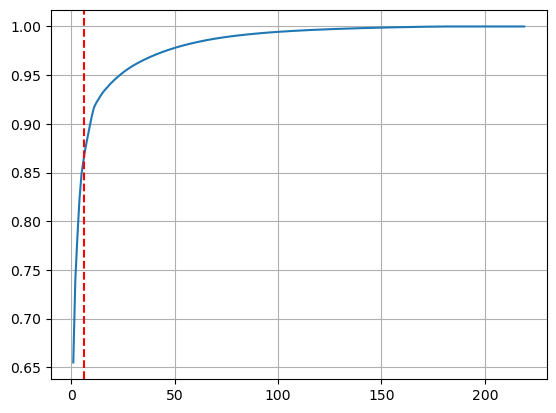

In [541]:
plt.plot(explained_variance[:,0],explained_variance[:,1])
plt.axvline(x = K_loadings, color='red', linestyle='--', label=f'')
plt.grid(True)

In [542]:
X_dimreduc = PCA_dimreduc(X, X, 0.85)[0]
X_dimreduc.shape

(3286, 6)

def DARMA_likelihood(rho, omega, alpha, phi):
    T=len(Y)
    
    sigma2=np.zeros(T)
    z = np.zeros(T)
    e=np.zeros(T)
    logli=np.zeros(T)
    
    for t in range(2,T):
        sigma2[t] = omega + alpha*Y[t-1]**2
        z[t] = phi * ( (Y[t-1] -(1+rho) * Y[t-2]) / np.sqrt(omega + alpha*Y[t-2]**2))

        e[t] = Y[t] -(1+rho) * Y[t-1] - np.sqrt(sigma2[t]) * z[t]

        logli[t]= -0.5 * np.log(sigma2[t]) -0.5 * e[t]**2 / sigma2[t]
    
    LogL=-np.sum(logli)
    
    return LogL

def optim(x):
    rh, ome, alp, ph = x
    return DARMA_likelihood(rho = rh, omega = ome, alpha = alp, phi = ph)

Par0=np.array([0.0, 0.05, 0.5, 0.0]) #initial guesses
res = sci_optim.minimize(optim, Par0, method='SLSQP', bounds = ((None,None), (0,None), (0,None), (None,None)))
rho_est, omega_est, alpha_est, phi_est = res.x
rho_est, omega_est, alpha_est, phi_est

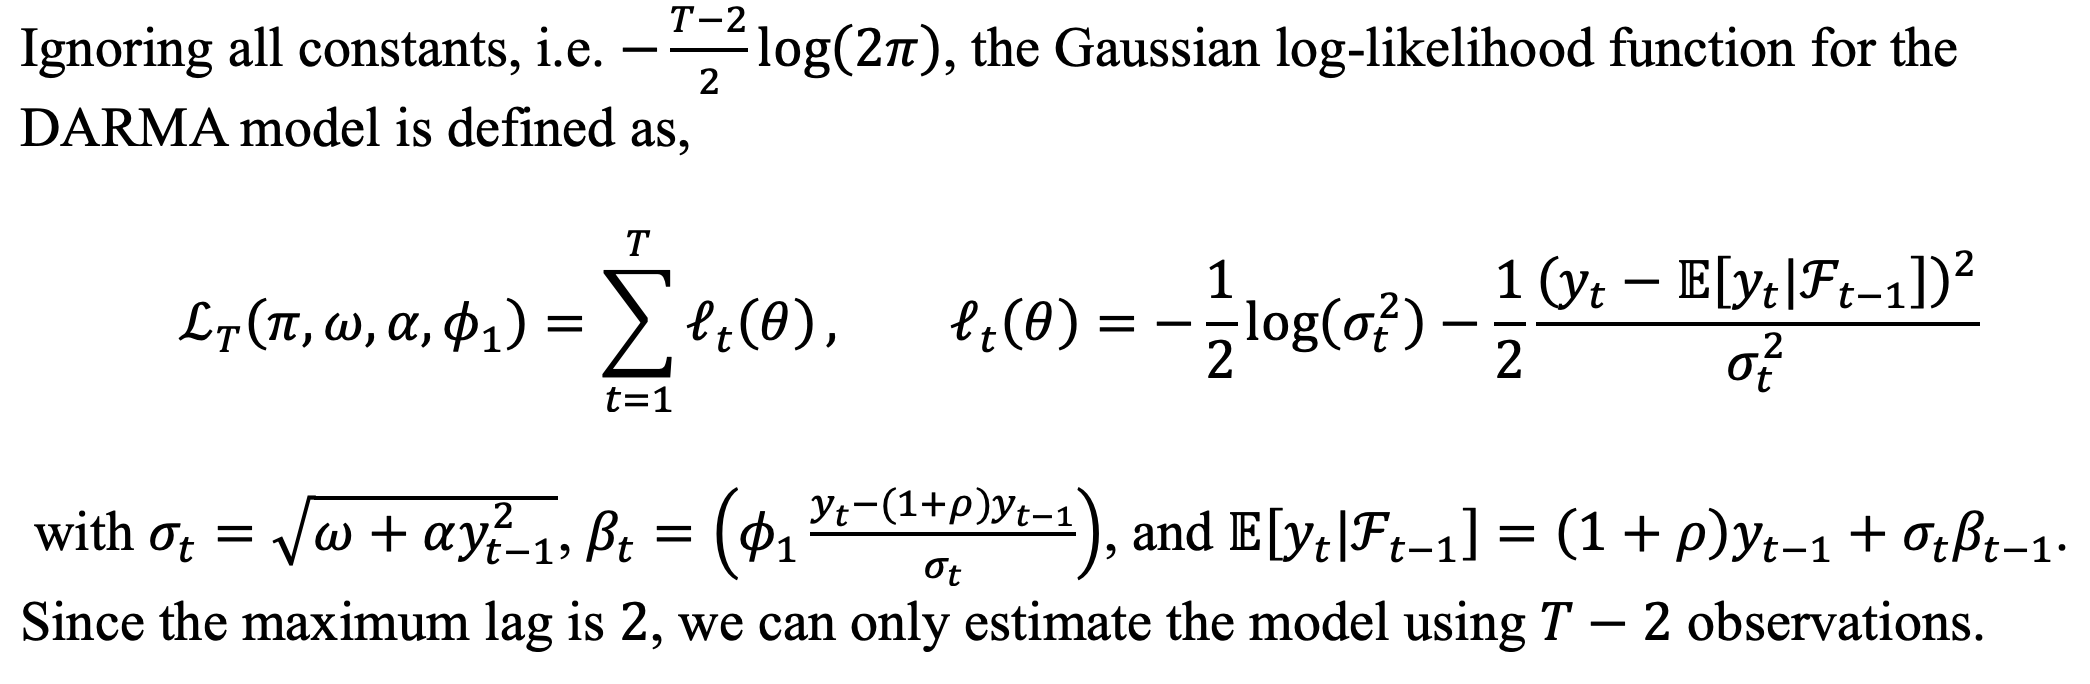

In [543]:
rho, omega, alpha, phi = rho_est, omega_est, alpha_est, phi_est # set only for testing

max_lag = 2 # maximum lag in the model
start_index = -1 # set -1 since the latest time series observation is the last value in Y
stop_index = -(len(Y)-(max_lag - 1))
t = np.arange(start = start_index, stop = stop_index, step = -1)

# define functions at time t
y = lambda t: (Y[t])
sigma = lambda t: np.sqrt(omega + alpha * (y(t-1) ** 2))
beta = lambda t: phi * ( y(t) - (1 + rho) * y(t-1) ) / sigma(t)
cond_mean = lambda t: ((1 + rho) * y(t-1) + sigma(t) * beta(t-1))

# compute sum of likelihood contributions
first_term = -1/2 * np.log(sigma(t))
second_term = -1/2 * (y(t) - cond_mean(t))**2 / sigma(t)**2
L_t = np.sum(first_term + second_term)
L_t


-10271.278778563283

In [652]:
def optimize_weights(X_test):
    """
    Optimize weights to minimize the objective function given X_test.
    
    Parameters:
    - X_test: np.ndarray, shape (n, m) where n is the number of samples and m is the number of features
    
    Returns:
    - optimal_weights: np.ndarray, the optimal weights
    """
    
    # Define the objective function to minimize
    def objective_function(weights):
        # Perform matrix multiplication: result will be a vector with shape (n,)
        result = X_test @ weights  # Dot product for each row of X_test
        return np.sum(result)  # Return the sum of the result for minimization

    # Initial guess for the weights (e.g., uniform weights)
    initial_weights = np.ones(X_test.shape[1]) * 0.3

    # Bounds for the weights (e.g., between 0 and 1)
    bounds = [(0, 1) for _ in range(X_test.shape[1])]

    # Perform the optimization
    result = minimize(objective_function, initial_weights, bounds=bounds)

    # Return the optimal weights
    return result.x

In [649]:
optimize_weights(X_test)

array([1., 1., 0., 1., 0., 0.])

In [663]:
def MLE_DARMA(Y):
    # X variables.. 
    def loglikelihood_function(params):

        rho, omega, alpha, phi = params
        
        # define time t
        max_lag = 2 # maximum lag in the model
        start_index = -1 # set -1 since the latest time series observation is the last value in Y
        stop_index = -(len(Y)-(max_lag - 1))
        t = np.arange(start = start_index, stop = stop_index, step = -1)
        
        # define functions at time t
        y = lambda t: (Y[t])
        sigma = lambda t: np.sqrt(omega + alpha * (y(t-1) ** 2))
        beta = lambda t: phi * ( y(t) - (1 + rho) * y(t-1) ) / sigma(t)
        cond_mean = lambda t: ((1 + rho) * y(t-1) + sigma(t) * beta(t-1))
        
        # compute sum of likelihood contributions
        first_term = -1/2 * np.log(sigma(t))
        second_term = -1/2 * (y(t) - cond_mean(t))**2 / sigma(t)**2
        L_t = np.sum(first_term + second_term)
        
        return -L_t
    
    # initialise parameters
    rho_init = 0.0
    omega_init = 0.05
    alpha_init = 0.5
    phi_init = 0.01
    init_params = np.array([rho_init, omega_init, alpha_init, phi_init])

    # set parameter bounds
    rho_bound = (None,None)
    omega_bound = (0,None)
    alpha_bound = (0,None)
    phi_bound = (None,None)
    bounds_params = (rho_bound, omega_bound, alpha_bound, phi_bound)

    MLE_estimates = sci_optim.minimize(loglikelihood_function, init_params, method='SLSQP', bounds = bounds_params)

    return MLE_estimates.x


In [664]:
Y = y_train[0]
Y.shape

MLE_DARMA(Y)

array([-3.95160257e-03,  5.21625257e+04,  1.75941970e-01, -1.96349575e-01])

In [ ]:
def optim(x):
    rh, ome, alp, ph = x
    return DARMA_likelihood(rho = rh, omega = ome, alpha = alp, phi = ph)

Par0=np.array([0.0, 0.05, 0.5, 0.0]) #initial guesses
res = sci_optim.minimize(optim, Par0, method='SLSQP', bounds = ((None,None), (0,None), (0,None), (None,None)))
rho_est, omega_est, alpha_est, phi_est = res.x